In [1]:
import numpy as np
import tensorflow as tf
import keras.api as keras
from keras.api.layers import *
import matplotlib.pyplot as plt

2025-03-15 23:18:57.160652: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742091537.176598  106558 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742091537.181527  106558 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-15 23:18:57.197536: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


I0000 00:00:1742091541.078531  106558 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9927 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


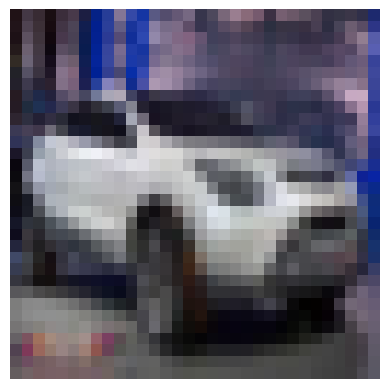

In [2]:
(x_train,y_train),(_,_) = keras.datasets.cifar10.load_data()

x_train = x_train[y_train[:,0] == 1]
x_train = tf.cast(x_train,tf.float32)/255.

n = np.random.randint(0,x_train.shape[0])

data = tf.data.Dataset.from_tensor_slices((x_train)).shuffle(x_train.shape[0]).batch(64,drop_remainder=True)

complete_hist = {
    'loss_dis': [],
    'loss_gen': [],
}

plt.imshow(x_train[n])
plt.axis(False)
plt.show()

In [3]:
def create_discriminator():
    
    input = Input((32,32,3))

    x = Conv2D(64,3,1,'same')(input) # output = (32,32)
    x = LeakyReLU(.2)(x)

    x = Conv2D(128,3,2,'same')(x) # output = (16,16)
    x = LeakyReLU(.2)(x)

    x = Conv2D(128,3,2,'same')(x) # output = (8,8)
    x = LeakyReLU(.2)(x)

    x = Conv2D(256,3,2,'same')(x) # output = (4,4)
    x = LeakyReLU(.2)(x)

    x = Flatten()(x)
    x = Dropout(.8)(x)
    x = Dense(1)(x)
    x = Activation('sigmoid')(x)

    return keras.Model(input,x,name='Discriminator')

def create_generator():
    
    input = Input((1024,))

    x = Dense(4*4*256)(input)
    x = LeakyReLU(.2)(x)
    x = Reshape((4,4,256))(x)

    x = Conv2DTranspose(512,3,2,'same')(x) # output = (8,8)
    x = LeakyReLU(.2)(x)
    x = Conv2D(64,3,1,'same')(x)
    x = LeakyReLU(.2)(x)

    x = Conv2DTranspose(256,3,2,'same')(x) # output = (16,16)
    x = LeakyReLU(.2)(x)
    x = Conv2D(64,3,1,'same')(x)
    x = LeakyReLU(.2)(x)

    x = Conv2DTranspose(128,3,2,'same')(x) # output = (32,32)
    x = LeakyReLU(.2)(x)
    
    x = Conv2D(3,3,1,'same')(x)
    x = Activation('sigmoid')(x)

    return keras.Model(input,x,name='Generator')

gen = create_generator()
dis = create_discriminator()
gen.summary()

Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │     4,198,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 512)      │     1,180,160 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 8, 8, 64)       │       294,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 256)    │       147,712 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 128)    │        73,856 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 3)      │         3,459 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 3)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,046,083 (23.06 MB)

 Trainable params: 6,046,083 (23.06 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
bce = keras.losses.BinaryCrossentropy()
gen_opt = keras.optimizers.Adam(5e-5,.5)
dis_opt = keras.optimizers.Adam(1e-5,.5)
n = 5
noise_out = tf.random.normal((n**2,1024))

In [5]:
@tf.function
def train_step():
    gen_loss,dis_loss = 0.,0.
    gen_loss_iter,dis_loss_iter = 0.,0.
    for batch in data:
        
        noise = tf.random.normal((128,1024))

        with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
            fake_imgs = gen(noise,training=True)
            true_labels = dis(batch,training=True)
            fake_labels = dis(fake_imgs,training=True)

            gen_loss_iter = bce(tf.ones_like(fake_labels),fake_labels)
            dis_loss_iter = bce(tf.ones_like(true_labels),true_labels) + bce(tf.zeros_like(fake_labels),fake_labels)
        
        gen_gras = gen_tape.gradient(gen_loss_iter,gen.trainable_variables)
        gen_opt.apply_gradients(zip(gen_gras,gen.trainable_variables))

        dis_grads = dis_tape.gradient(dis_loss_iter,dis.trainable_variables)
        dis_opt.apply_gradients(zip(dis_grads,dis.trainable_variables))

        gen_loss += gen_loss_iter
        dis_loss += dis_loss_iter
        gen_loss_iter,dis_loss_iter = 0.,0.

    return gen_loss/tf.cast(len(data),tf.float32),dis_loss/tf.cast(len(data),tf.float32)

In [6]:
EPOCHS = 1400
EPOCH_SAMPLE = 10

loss_dis, loss_gan = 0.,0.
loss_list = np.zeros((EPOCHS,2))
for i in range(EPOCHS):

    # Histórico de Loss
    loss_gen, loss_dis = train_step()
    complete_hist['loss_gen'].append(loss_gen)
    complete_hist['loss_dis'].append(loss_dis)
    
    # Iteração das épocas
    if i % EPOCH_SAMPLE == 0:
        # Print Loss
        print(f'Ep = {i} | Loss_gen = {loss_gen:.4f}; Loss_dis = {loss_dis:.4f}')
        # Salvar uma amostra das imagens
        img_fake = gen(noise_out)
        fig, ax = plt.subplots(n,n,figsize=(1,1))
        ax = ax.ravel()
        for ii in range(n**2):
            ax[ii].imshow(img_fake[ii])
            ax[ii].set_axis_off()
        plt.savefig(f'imgs/fig{i-1+len(complete_hist["loss_gen"])}.png',dpi=1000)
        plt.close()

        plt.Figure()
    plt.semilogy(np.array(complete_hist['loss_gen']),label='GEN')
    plt.semilogy(np.array(complete_hist['loss_dis']),label='DIS')
    plt.legend()
    plt.grid(True,'minor')
    plt.savefig('loss.png')
    plt.close()


print('==================== COMPLETE ====================')

# plt.Figure()
# plt.plot(loss_list[:,0],label='Discriminator')
# plt.plot(loss_list[:,1],label='GAN')
# plt.legend()
# plt.show()

I0000 00:00:1742091544.907135  106670 cuda_dnn.cc:529] Loaded cuDNN version 90300


Ep = 0 | Loss_gen = 0.6844; Loss_dis = 1.3503
Ep = 10 | Loss_gen = 7.4416; Loss_dis = 0.0017
Ep = 20 | Loss_gen = 6.9308; Loss_dis = 0.0037
Ep = 30 | Loss_gen = 0.6364; Loss_dis = 1.4188
Ep = 40 | Loss_gen = 0.7770; Loss_dis = 1.3424
Ep = 50 | Loss_gen = 0.7436; Loss_dis = 1.3398
Ep = 60 | Loss_gen = 0.7376; Loss_dis = 1.3406
Ep = 70 | Loss_gen = 0.7568; Loss_dis = 1.3435
Ep = 80 | Loss_gen = 0.7584; Loss_dis = 1.3575
Ep = 90 | Loss_gen = 0.7425; Loss_dis = 1.3604
Ep = 100 | Loss_gen = 0.7356; Loss_dis = 1.3371
Ep = 110 | Loss_gen = 0.7391; Loss_dis = 1.3791
Ep = 120 | Loss_gen = 0.7163; Loss_dis = 1.3567
Ep = 130 | Loss_gen = 0.7273; Loss_dis = 1.3763
Ep = 140 | Loss_gen = 0.7250; Loss_dis = 1.3528
Ep = 150 | Loss_gen = 0.7005; Loss_dis = 1.3609
Ep = 160 | Loss_gen = 0.7270; Loss_dis = 1.3504
Ep = 170 | Loss_gen = 0.7438; Loss_dis = 1.3647
Ep = 180 | Loss_gen = 0.7165; Loss_dis = 1.3483
Ep = 190 | Loss_gen = 0.7335; Loss_dis = 1.3589
Ep = 200 | Loss_gen = 0.8014; Loss_dis = 1.3106
Ep 

In [7]:
gen.save('generator_cars.keras')
dis.save('discriminator_cars.keras')

Média True = 0.6148 
Média False = 0.4296


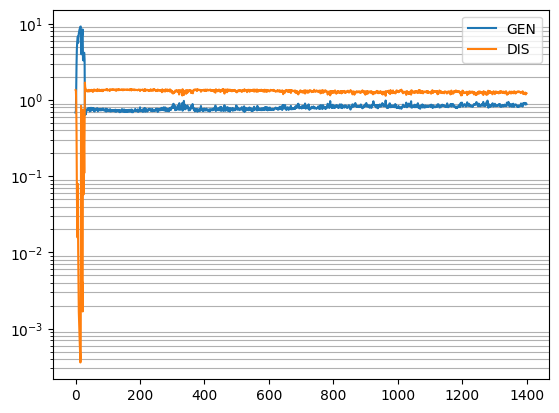

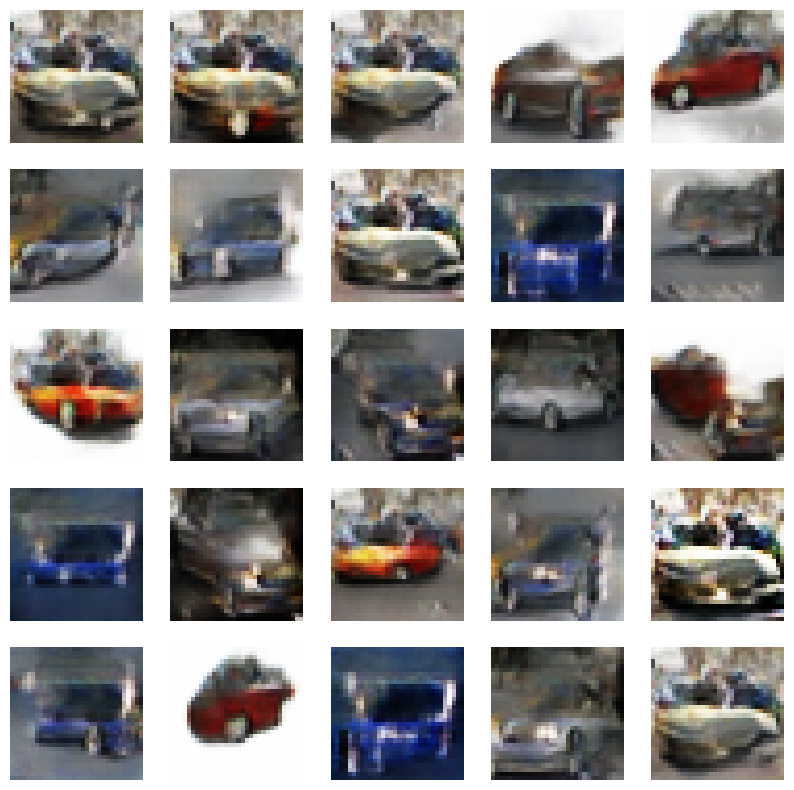

In [13]:
n = 5

noise_out = tf.random.normal((1000,1024))

img_fake = gen(noise_out)
out_true = dis(x_train[0:1000])
out_fake = dis(gen(tf.random.uniform((1000,1024))))

print(f'Média True = {tf.reduce_mean(out_true):.4f} \nMédia False = {tf.reduce_mean(out_fake):.4f}')

plt.Figure()
plt.semilogy(np.array(complete_hist['loss_gen']),label='GEN')
plt.semilogy(np.array(complete_hist['loss_dis']),label='DIS')
plt.legend()
plt.grid(True,'minor')
plt.show()


fig, ax = plt.subplots(n,n,figsize=(10,10))
ax = ax.ravel()

for i in range(n**2):
    ax[i].imshow(img_fake[i])
    ax[i].set_axis_off()
plt.show()